# Draft `pyGIMLi(emg3d)` - Data Creation

**An attempt at using `pyGIMLi` as an inversion framework for `emg3d` computations.**

=> Create an environment using the provided `environment.yml`: `mamba env create`.

For developing purposes, we take a very simple model and survey:
- Simple double-halfspace model water-subsurface with a resistive block.
- Survey: A single 2D line, 7 sources, 7 frequencies.

In [1]:
import emg3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

## Create a survey

In [2]:
azimuth = 0.0
elevation = 0.0

# Receiver line
rec_x = np.arange(-7000, 7001, 250.)
rec_y = 0.0
rec_z = 0.0
rec = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.RxElectricPoint,
        (rec_x, rec_y, rec_z, azimuth, elevation)
)

# Sources
src_x = np.array([-6000, -4000, -2000, 0.0, 2000, 4000, 6000])
src_y = 0.0
src_z = 50.0
src = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.TxElectricDipole,
        (src_x, src_y, src_z, azimuth, elevation),
        strength=1000,
)

# Frequencies - roughly log-spaced from 0.1 Hz to 5 Hz
frequencies = np.round(np.logspace(-1, 0.7, 7), 1)

# Create a survey
survey = emg3d.surveys.Survey(
    sources=src,
    receivers=rec,
    frequencies=frequencies,
    noise_floor=1e-15,
    relative_error=0.03,
)

# QC
survey

:: Survey ::

<xarray.Dataset>
Dimensions:   (src: 7, rec: 57, freq: 7)
Coordinates:
  * src       (src) <U6 'TxED-1' 'TxED-2' 'TxED-3' ... 'TxED-6' 'TxED-7'
  * rec       (rec) <U7 'RxEP-01' 'RxEP-02' 'RxEP-03' ... 'RxEP-56' 'RxEP-57'
  * freq      (freq) <U3 'f-1' 'f-2' 'f-3' 'f-4' 'f-5' 'f-6' 'f-7'
Data variables:
    observed  (src, rec, freq) complex128 (nan+nanj) (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-15
    relative_error:  0.03

## Create a simple model

In [3]:
hx = np.ones(142)*100.0
hy = np.ones(62)*100.0
hz = np.ones(24)*100.0
grid = emg3d.TensorMesh([hx, hy, hz], [-7100, -3100, -2300])

# QC
grid

TensorMesh: 211,296 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    142     -7,100.00      7,100.00    100.00    100.00    1.00
   y     62     -3,100.00      3,100.00    100.00    100.00    1.00
   z     24     -2,300.00        100.00    100.00    100.00    1.00

Model: resistivity; isotropic; 142 x 62 x 24 (211,296)

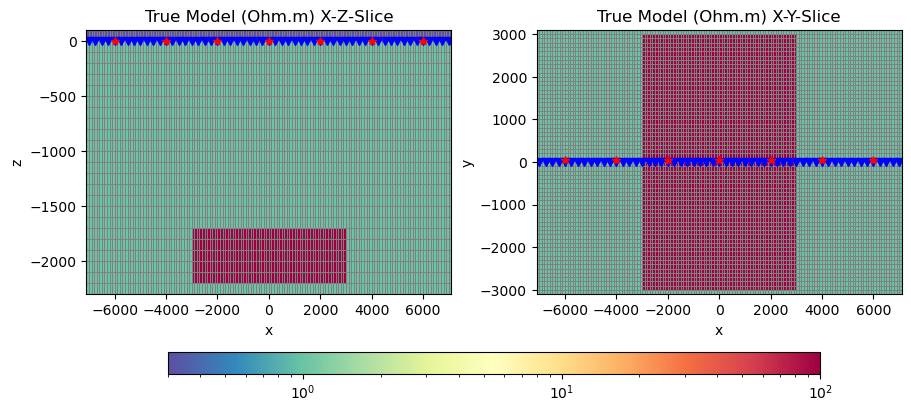

In [4]:
# Initial model
model = emg3d.Model(grid, 1.0)
model.property_x[:, :, -1:] = 0.3

# Model with a target
tg_model = model.copy()
tg_model.property_x[41:-41, 1:-1, 1:6] = 100.0

popts = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True, sharex=True)

opts = {'v_type': 'CC', 'normal': 'Y', 'pcolor_opts': popts}
out1, = grid.plot_slice(tg_model.property_x.ravel('F'), ax=ax1, **opts)
ax1.set_title(f"True Model (Ohm.m) X-Z-Slice")
ax1.plot(rec_coords[0], rec_coords[1], 'bv')
ax1.plot(src_coords[0], src_coords[1], 'r*')
    
opts = {'v_type': 'CC', 'normal': 'Z', 'pcolor_opts': popts}
out2, = grid.plot_slice(tg_model.property_x.ravel('F'), ax=ax2, ind=1, **opts)
ax2.set_title(f"True Model (Ohm.m) X-Y-Slice")
ax2.plot(rec_coords[0], rec_coords[2], 'bv')
ax2.plot(src_coords[0], src_coords[2], 'r*')

plt.colorbar(out1, ax=(ax1, ax2), orientation='horizontal', fraction=.1, shrink=.8, aspect=30)

# QC
tg_model

## Generate synthetic data

In [5]:
simulation = emg3d.simulations.Simulation(
    survey=survey,
    model=tg_model,
    gridding='both',
    max_workers=50,
    receiver_interpolation='linear',  # Currently necessary for the gradient
    gridding_opts={'vector': 'xyz'},
)

# Let's QC our Simulation instance
simulation

:: Simulation ::

- Survey: 7 sources; 57 receivers; 7 frequencies
- Model: resistivity; isotropic; 142 x 62 x 24 (211,296)
- Gridding: Frequency- and source-dependent grids; 160 x 80 x 32 (409,600) - 160 x 80 x 40 (512,000)

In [6]:
simulation.compute(observed=True, min_offset=1000)
del survey.data['synthetic']  # Observed (with noise) remains stored

Compute efields            0/49  [00:00]

In [7]:
emg3d.save('pginv-7x7.h5', model=model, survey=survey, true_model=tg_model)

Data saved to «/palmyra/data/dieterwerthmul/dev-pygimli-emg3d/pginv-7x7.h5»
[emg3d v1.8.2 (format 1.0) on 2023-12-18T22:05:34.473820].


## Compute responses for initial model, QC that the data is sensitive to the target

In [8]:
init_sim = emg3d.simulations.Simulation(
    survey=survey,
    model=model,
    gridding='both',
    max_workers=50,
    receiver_interpolation='linear',  # Currently necessary for the gradient
    gridding_opts={'vector': 'xyz'},
)

init_sim.compute()

Compute efields            0/49  [00:00]

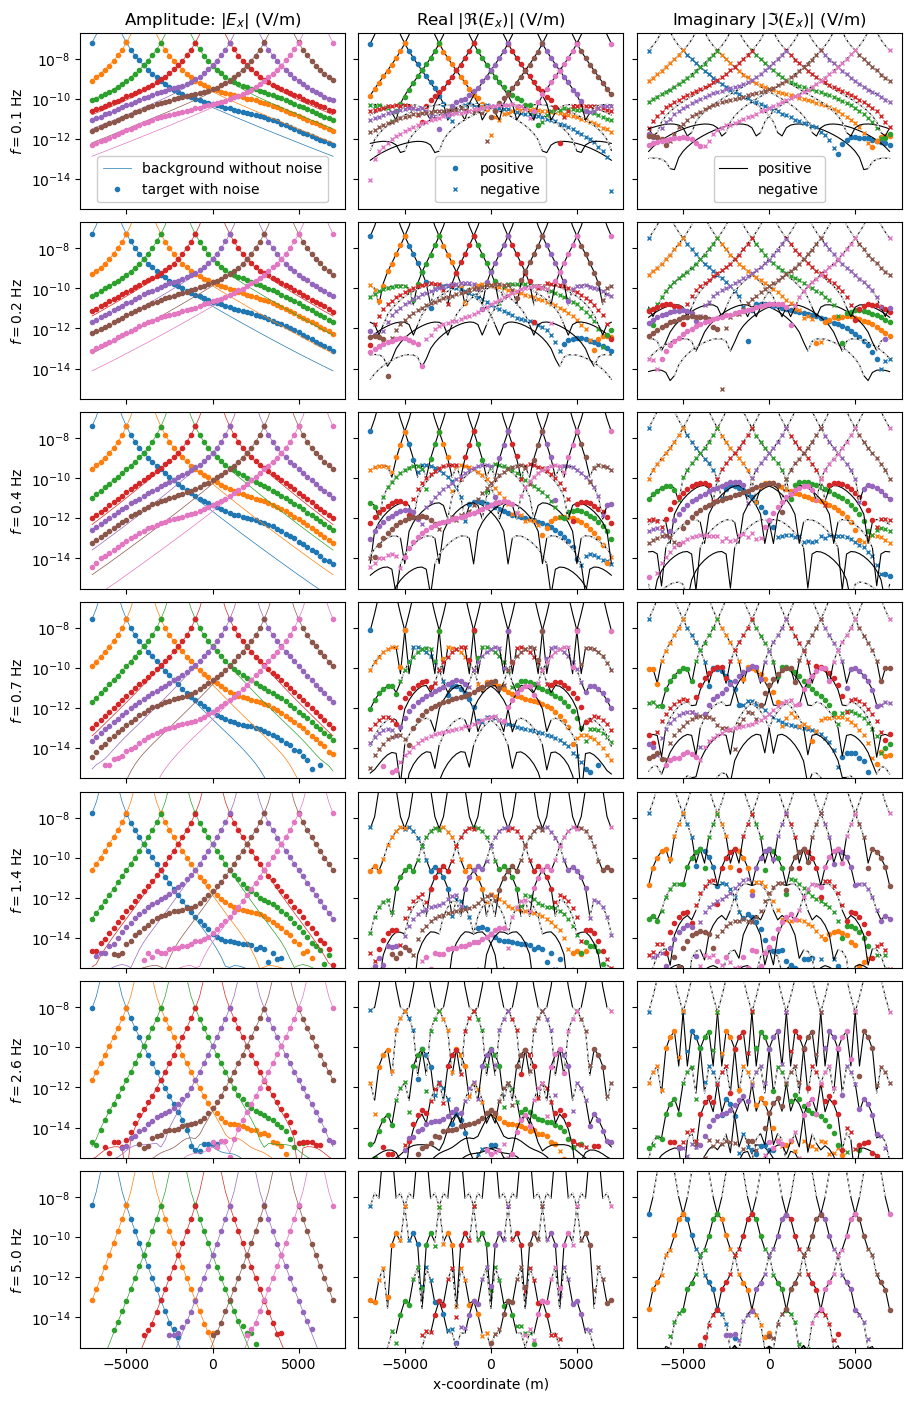

In [9]:
def pos(data):
    """Return positive data; set negative data to NaN."""
    return np.where(data > 0, data, np.nan)


height = survey.shape[2]*1.7+2
fig, axs = plt.subplots(survey.shape[2], 3, figsize=(9, height), constrained_layout=True, sharex=True, sharey=True)
axs = np.atleast_2d(axs)  # So it works if only 1 freq

obs = init_sim.data.observed
syn = init_sim.data.synthetic
rec_coords = survey.receiver_coordinates()

for ii, freq in enumerate(survey.frequencies.keys()):
    for i, src in enumerate(survey.sources.keys()):
        #if i in [1, 3, 5]:
        #    continue
        
        axs[ii, 0].plot(rec_coords[0], abs(syn.loc[src, :, freq].data), f"C{i}-", lw=0.5,
                        label='background without noise' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], abs(syn.loc[src, :, freq].data.real), f"k-", lw=0.8)
        axs[ii, 1].plot(rec_coords[0], pos(-syn.loc[src, :, freq].data.real), f"w--", lw=0.8)
        axs[ii, 2].plot(rec_coords[0], abs(syn.loc[src, :, freq].data.imag), f"k-", lw=0.8,
                        label='positive' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(-syn.loc[src, :, freq].data.imag), f"w--", lw=0.8,
                        label='negative' if i == 0 else '')
        
        axs[ii, 0].plot(rec_coords[0], abs(obs.loc[src, :, freq].data), f"C{i}.",
                        label='target with noise' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(obs.loc[src, :, freq].data.real), f"C{i}.",
                        label='positive' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(-obs.loc[src, :, freq].data.real), f"C{i}x", ms=3,
                        label='negative' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(obs.loc[src, :, freq].data.imag), f"C{i}.")
        axs[ii, 2].plot(rec_coords[0], pos(-obs.loc[src, :, freq].data.imag), f"C{i}x", ms=3)

    axs[ii, 0].set_ylabel(f'$f={survey.frequencies[freq]}$ Hz')     

        
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylim([3e-16, 2e-7])

axs[0, 0].set_title('Amplitude: $|E_x|$ (V/m)')
axs[0, 1].set_title('Real $|\Re(E_x)|$ (V/m)')
axs[0, 2].set_title('Imaginary $|\Im(E_x)|$ (V/m)')

axs[0, 0].legend(framealpha=1)
axs[0, 1].legend(framealpha=1)
axs[0, 2].legend(framealpha=1)

axs[-1, 1].set_xlabel('x-coordinate (m)')
plt.show()

In [10]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Mon Dec 18 22:06:25 2023 CET

                OS : Linux
            CPU(s) : 256
           Machine : x86_64
      Architecture : 64bit
               RAM : 1007.1 GiB
       Environment : Jupyter
       File system : xfs

  Python 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37)
  [GCC 12.3.0]

             numpy : 1.24.4
             scipy : 1.11.4
             numba : 0.58.1
             emg3d : 1.8.2
           empymod : 2.2.2
            xarray : 2023.12.0
        discretize : 0.10.0
              h5py : 3.9.0
        matplotlib : 3.8.2
              tqdm : 4.66.1
           IPython : 8.18.1
--------------------------------------------------------------------------------